# Section 3_1 MLP networks


## creation of the dataset (target values)

In [13]:

from dolfinx import mesh as msh, fem, io, default_scalar_type
from mpi4py import MPI
import os
import torch
import numpy as np
import ufl
from mpi4py import MPI
import numpy as np
from utils.FEniCSx_solver import FEniCSx_solver
from utils.FEniCSx_PyTorch_interface import FEniCSx_PyTorch_interface


class model(torch.nn.Module):
    def __init__(self, device, dtype, dir= None):
        super().__init__()
        self.w = torch.nn.Parameter(torch.rand(8, device=device, dtype=dtype, requires_grad=True))
        if dir is not None:
            self.load_state_dict(torch.load(dir, weights_only=True))

    
    def forward(self, x):
        a = torch.sqrt(x[0]**2+x[1]**2)
        b = torch.sqrt(x[2]**2+x[3]**2)
        c = torch.sqrt(x[4]**2+x[5]**2)
        s = (a+b+c)/2
        A = torch.sqrt(s*((s-a)*(s-b)*(s-c)))
        h_K = 4*A/torch.sqrt(a**2+b**2+c**2)
        limit = h_K**2/(1e-8*48)
        low = torch.zeros_like(limit)
        z1 = torch.matmul(self.w, x)
        Pe = z1/(2*1e-8)
        z2 = z1/2*(1/torch.tanh(Pe)-(2*1e-8)*z1)
        supg_params = torch.clip(z2, min = low, max=limit)
        return supg_params
    
model_init='data/example_2_1/models/nn_init.pth'

nn= model(device='cpu', dtype=torch.float64, dir=model_init)
w = nn.state_dict()['w'].detach().numpy()


mean = 0


def mesh_to_x(mesh, cell_ind_to_grid, epsK, bK, cK, fK, device=None, dtype=None):
    lst = []
    for v in mesh.geometry.x[:,0:2][mesh.geometry.dofmap]:
        xK = np.concat((v, epsK, bK, cK, fK), axis=None)
        lst.append(xK)

    xnp=np.array(lst).T
    x = torch.tensor(xnp[:,cell_ind_to_grid], requires_grad=False, device=device, dtype=dtype)

    x = torch.nn.functional.pad(x, pad=(1,1,1,1))

    # left column: set v0, v1 to v0, v1 of neighboring column
    x[0:4,1:ny+1, 0] = x[0:4,1:ny+1, 1]
    # set collapsed vertices v2 and v3 to v1 at the same position
    x[4:6,1:ny+1, 0] = x[2:3,1:ny+1, 0]
    x[6:8,1:ny+1, 0] = x[2:3,1:ny+1, 0]


    # right column: set v0 to v2 of neighboring column
    x[0:4,1:ny+1, -1] = x[4:8,1:ny+1, -1 -1]
    # set collapsed vertices v2 and v3 to v1 at the same position
    x[4:6,1:ny+1, -1] = x[2:3,1:ny+1, -1]
    x[6:8,1:ny+1, -1] = x[2:3,1:ny+1, -1]


    # top row: set v0 to v0 of neighboring row
    x[0:2,0,1:nx+1] = x[2:4,1,1:nx+1]
    # top row: set v1 to v3 of neighboring row
    x[2:4,0,1:nx+1] = x[6:8,1,1:nx+1]
    # set collapsed vertices v2 and v3 to v1 at the same position
    x[4:6,0,1:nx+1] = x[2:3,0,1:nx+1]
    x[6:8,0,1:nx+1] = x[2:3,0,1:nx+1]

    # bottom row: set v0 to v0 of neighboring row
    x[0:2,-1,1:nx+1] = x[0:2,-1-1,1:nx+1]
    # bottom row: set v1 to v2 of neighboring row
    x[2:4,-1,1:nx+1] = x[4:6,-1-1,1:nx+1]
    # set collapsed vertices v2 and v3 to v1 at the same position
    x[4:6,-1,1:nx+1] = x[2:3,-1,1:nx+1]
    x[6:8,-1,1:nx+1] = x[2:3,-1,1:nx+1]

    # set upper left corner to v0 of neigboring horizontal edge
    x[0:2,0,0] = x[0:2,0,1]
    # set remaining vertices to v0
    x[2:4,0,0] = x[0:2,0,0]
    x[4:6,0,0] = x[0:2,0,0]
    x[6:8,0,0] = x[0:2,0,0]

    # set bottom left corner to v0 of neighboring horizontal edge
    x[0:2,-1,0] = x[0:2,-1,1]
    # set remaining vertices to v0
    x[2:4,-1,0] = x[0:2,-1,0]
    x[4:6,-1,0] = x[0:2,-1,0]
    x[6:8,-1,0] = x[0:2,-1,0]

    # set upper right corner to v1 of neighboring horizontal edge
    x[0:2,0,-1] = x[2:4,0,-1-1]
    # set remaining vertices to v0
    x[2:4,0,-1] = x[0:2,0,-1]
    x[4:6,0,-1] = x[0:2,0,-1]
    x[6:8,0,-1] = x[0:2,0,-1]

    # set bottom right corner to v1 of neighboring horizontal edge
    x[0:2,-1,-1] = x[2:4,-1,-1-1]
    # set remaining vertices to v0
    x[2:4,-1,-1] = x[0:2,-1,-1]
    x[4:6,-1,-1] = x[0:2,-1,-1]
    x[6:8,-1,-1] = x[0:2,-1,-1]

    # set the dirichlet boundary condition
    x[11,0,:] = 1
    x[11,-1,:] = 1
    x[11,:,0] = 1
    x[11,:,-1] = 1


    return x



def create_target_values(mesh, bK):
    Wh = fem.functionspace(mesh, ('P', 2))
    mesh.topology.create_connectivity(mesh.topology.dim - 1, mesh.topology.dim)
    boundary_facets = msh.exterior_facet_indices(mesh.topology)
    boundary_dofs = fem.locate_dofs_topological(Wh, mesh.topology.dim-1, boundary_facets)

    eps = fem.Constant(mesh, default_scalar_type(1e-8))

    b = ufl.as_vector((fem.Constant(mesh, default_scalar_type(bK[0])),fem.Constant(mesh, default_scalar_type(bK[1]))))
    f = fem.Constant(mesh, default_scalar_type(1.0))
    uh = fem.Function(Wh)

    x = ufl.SpatialCoordinate(mesh)
    if np.all(bK == np.array([1,0])) or np.all(bK == np.array([-1,0])):
        dir = 0
    else:
        dir = 1
    
    
    ex_exp = x[dir]*(1-ufl.exp(-(1-x[dir])/eps))* (1 - (((ufl.exp(-(1-x[(dir+1)%2])/eps)  + ufl.exp(-(x[(dir+1)%2])/eps)))- ufl.exp(-(1)/eps))/(1-ufl.exp(-1/eps)))

    if np.min(bK) < 0:
        ex_exp = (1-x[dir])*(1-ufl.exp(-(x[dir])/eps))* (1 - (((ufl.exp(-(1-x[(dir+1)%2])/eps)  + ufl.exp(-(x[(dir+1)%2])/eps)))- ufl.exp(-(1)/eps))/(1-ufl.exp(-1/eps)))

    
    exp = fem.Expression(ex_exp, Wh.element.interpolation_points())

    u_ex = fem.Function(Wh)
    u_ex.interpolate(exp)
    bcs = [fem.dirichletbc(fem.Constant(mesh, default_scalar_type(0.0)), boundary_dofs, Wh)]

    loss = (uh-u_ex)**2 * ufl.dx
    pde_data = mesh,Wh,uh,eps,b,None,f,None,bcs

    FEniCSx = FEniCSx_solver(pde_data=pde_data, loss_form=loss)

    lst = []
    bK = np.array([1,0])
    for v in mesh.geometry.x[:,0:2][mesh.geometry.dofmap]:
        xK = np.concat((v[2]-v[1], v[2]-v[0], v[1]-v[0], bK), axis=None)
        lst.append(xK)

    xnp=np.array(lst).T
    z1 = np.matmul(w, xnp)
    Pe = z1/(2*1e-8)
    supg_params = z1/2*(1/np.tanh(Pe)-(2*1e-8)*z1)

    FEniCSx.set_weights(supg_params)
    params = torch.tensor(supg_params, requires_grad=True)
    autograd_func = FEniCSx_PyTorch_interface.apply

    def fem_solver(weights):
        return autograd_func(weights, FEniCSx)

    optimizer = torch.optim.Adam([params])
    train_loss = 0
    for steps in range(iterations):
        optimizer.zero_grad()
        loss = fem_solver(params)
        loss.backward()
        # Backpropagation
        optimizer.step()

    train_loss += loss
    target = params
    return target



iterations = 500
comm = MPI.COMM_WORLD
epsK = 1e-8
cK = 0
fK = 1


num = 0

nx = 32
ny = 32
std = 1/(3*(nx+ny))

mesh = msh.create_unit_square(comm, nx, ny, msh.CellType.quadrilateral)
Yh = fem.functionspace(mesh, ('DG', 0))
pts = Yh.tabulate_dof_coordinates()
x = pts[:,0]
y = pts[:,1]
cell_ind_to_grid = np.lexsort((pts[:,0], -pts[:,1])).reshape(ny,nx)

vertices = mesh.geometry.x

cells = mesh.geometry.dofmap

element = mesh.geometry.cmap
mask= ~np.any((vertices[:,:2] == 0) | (vertices[:,:2] == 1), axis=1)
for bK in [np.array([1,0]), np.array([-1,0]), np.array([0,1]), np.array([0,-1])]:
    #with io.XDMFFile(mesh.comm, f"data/example_3_1/training_set/fem_data/mesh_{num}.xdmf", "w") as writer:
    #    writer.write_mesh(ms)
    x = mesh_to_x(mesh=mesh, cell_ind_to_grid=cell_ind_to_grid,epsK=epsK, bK=bK, cK=cK, fK=fK)
    torch.save(x, f'data/example_3_1/training_set/inputs/x_{num}.pt')
    t = create_target_values(mesh=mesh, bK=bK)
    torch.save(t, f'data/example_3_1/training_set/target_values/t_{num}.pt')
    num += 1
    print(f"trainset point: {num}")

for i in range(100):
    print(f"trainset point: {num}")
    for bK in [np.array([1,0]), np.array([-1,0]), np.array([0,1]), np.array([0,-1])]:
        noise = np.random.normal(mean, std, size=vertices.shape)
        noise[:,2] = 0
        new_vertices=vertices.copy()

        new_vertices[mask] += noise[mask]
        ms = msh.create_mesh(comm=comm, cells=cells, x=new_vertices, e=mesh.ufl_domain())
        
        #with io.XDMFFile(mesh.comm, f"data/example_3_1/training_set/fem_data/mesh_{num}.xdmf", "w") as writer:
        #    writer.write_mesh(ms)
        x = mesh_to_x(mesh=ms, cell_ind_to_grid=cell_ind_to_grid,epsK=epsK, bK=bK, cK=cK, fK=fK)
        torch.save(x, f'data/example_3_1/training_set/inputs/x_{num}.pt')
        t = create_target_values(mesh=ms, bK=bK)
        torch.save(t, f'data/example_3_1/training_set/target_values/t_{num}.pt')
        num += 1


num = 0

mesh = msh.create_unit_square(MPI.COMM_WORLD, nx, ny, msh.CellType.quadrilateral)

Yh = fem.functionspace(mesh, ('DG', 0))
pts = Yh.tabulate_dof_coordinates()
x = pts[:,0]
y = pts[:,1]
cell_ind_to_grid = np.lexsort((pts[:,0], -pts[:,1])).reshape(ny,nx)

vertices = mesh.geometry.x

cells = mesh.geometry.dofmap

element = mesh.geometry.cmap
mask= ~np.any((vertices[:,:2] == 0) | (vertices[:,:2] == 1), axis=1)
for i in range(40):
    print(f"testset point: {num}")
    for bK in [np.array([1,0]), np.array([-1,0]), np.array([0,1]), np.array([0,-1])]:
        noise = np.random.normal(mean, std, size=vertices.shape)
        noise[:,2] = 0
        new_vertices=vertices.copy()

        new_vertices[mask] += noise[mask]
        ms = msh.create_mesh(comm=comm, cells=cells, x=new_vertices, e=mesh.ufl_domain())
        #with io.XDMFFile(mesh.comm, f"data/example_3_1/training_set/fem_data/mesh_{num}.xdmf", "w") as writer:
        #    writer.write_mesh(ms)
        x = mesh_to_x(mesh=ms, cell_ind_to_grid=cell_ind_to_grid,epsK=epsK, bK=bK, cK=cK, fK=fK)
        torch.save(x, f'data/example_3_1/test_set/inputs/x_{num}.pt')
        t = create_target_values(mesh=ms, bK=bK)
        torch.save(t, f'data/example_3_1/test_set/target_values/t_{num}.pt')
        num += 1


trainset point: 1
trainset point: 2
trainset point: 3
trainset point: 4
trainset point: 4
trainset point: 8
trainset point: 12
trainset point: 16
trainset point: 20
trainset point: 24
trainset point: 28
trainset point: 32
trainset point: 36
trainset point: 40
trainset point: 44
trainset point: 48
trainset point: 52
trainset point: 56
trainset point: 60
trainset point: 64
trainset point: 68
trainset point: 72
trainset point: 76
trainset point: 80
trainset point: 84
trainset point: 88
trainset point: 92
trainset point: 96
trainset point: 100
trainset point: 104
trainset point: 108
trainset point: 112
trainset point: 116
trainset point: 120
trainset point: 124
trainset point: 128
trainset point: 132
trainset point: 136
trainset point: 140
trainset point: 144
trainset point: 148
trainset point: 152
trainset point: 156
trainset point: 160
trainset point: 164
trainset point: 168
trainset point: 172
trainset point: 176
trainset point: 180
trainset point: 184
trainset point: 188
trainset point

## Global MLP modules

In [14]:
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

from utils.supervised_dataset import supervised_dataset as dataset
from torch.utils.data import DataLoader
from utils.transforms import flattening_transform, reindex_transform, create_cell_ind_to_grid, create_flattening_index_set



class resblock(nn.Module):
    def __init__(self, layer):
        super().__init__()
        self.layer = layer

    def forward(self, x):
        z = self.layer(x)
        return z+x

class MLP_block(nn.Module):
    def __init__(
            self, 
            insize, 
            outsize, 
            activation, 
            normalization=None, 
            residual_connection=None, 
            Dropout=None, 
            p=0.5
        ):
        super().__init__()
        self.residual_connection = residual_connection
        components = [nn.Linear(insize, outsize), activation()]
        if normalization:
            components.append(normalization(outsize))
        if Dropout:
            components.append(nn.Dropout(p=p))
        self.layer = nn.Sequential(*components)
        if residual_connection:
            self.layer = resblock(self.layer)

            
    def forward(self, x):
        return self.layer(x) 
    
class const_featuresize_MLP(nn.Module):
    def __init__(
            self, 
            width, 
            depth, 
            activation,
            residual_connection=False, 
            normalization=False, 
            Dropout=None, 
            p=0.5
        ):
        super().__init__()
        layers = []
        for _ in range(depth-1):
            layers.append(
                MLP_block(
                    insize=width, 
                    outsize=width, 
                    activation=activation, 
                    normalization=normalization, 
                    residual_connection=residual_connection, 
                    Dropout=Dropout, 
                    p=p
                )
            )
        layers.append(
            MLP_block(
                insize=width, 
                outsize=width, 
                activation=activation, 
                normalization=None, 
                residual_connection=None, 
                Dropout=None, 
                p=p
            )
        )
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

    


class sMLP(torch.nn.Module):
    def __init__(
            self, 
            in_features, 
            cdim_MLP_width, 
            cdim_MLP_depth, 
            out_features, 
            activation, 
            residual_connection=False, 
            normalization=False, 
            Dropout=False, 
            p=0.5, 
            dir=None
        ):
        super().__init__()
        if cdim_MLP_depth == 0:
            self.ffwd = nn.Sequential(
                MLP_block(
                    insize=in_features, 
                    outsize=out_features, 
                    activation=activation, 
                )
            )
        if cdim_MLP_depth == 1:
            self.ffwd = nn.Sequential(
                MLP_block(
                    insize=in_features, 
                    outsize=out_features, 
                    activation=activation, 
                    normalization=normalization, 
                    Dropout=Dropout, 
                    p=p
                ),
                const_featuresize_MLP(
                    width=out_features, 
                    depth=1, 
                    activation=activation, 
                    residual_connection=residual_connection
                )
            )
        else:
            self.ffwd = nn.Sequential(
                MLP_block(
                    insize=in_features, 
                    outsize=cdim_MLP_width, 
                    activation=activation, 
                    normalization=normalization, 
                    Dropout=Dropout, 
                    p=p
                ),
                const_featuresize_MLP(
                    width=cdim_MLP_width, 
                    depth=cdim_MLP_depth, 
                    activation=activation, 
                    residual_connection=residual_connection, 
                    normalization=normalization, 
                    Dropout=Dropout, 
                    p=p
                ),
                MLP_block(
                    insize=cdim_MLP_width, 
                    outsize=out_features, 
                    activation=activation, 
                )
        )
        if dir:
            self.load_state_dict(torch.load(dir, weights_only=True))

    def forward(self, x):
        y_pred = self.ffwd(x)
        return y_pred



## Global MLP datasets and training loops

In [15]:
def train_loop(dataloader, nn, optimizer, loss_fn):
    num_batches = len(dataloader)
    nn.train()
    train_loss = 0.0
    for batch, (x, t) in enumerate(dataloader):
        y_pred = nn(x)

        loss = loss_fn(y_pred,t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= num_batches
    print(f"Train loss: {train_loss:>7f}")
    return(train_loss)

def test_loop(dataloader, nn, loss_fn):
    nn.eval()
    num_batches = len(dataloader)
    test_loss = 0.0

    with torch.no_grad():
        for x, t in dataloader:
            y_pred = nn(x)

            loss = loss_fn(y_pred,t)

            test_loss += loss.item()

    test_loss /= num_batches
    print(f"Test loss: {test_loss:>8f} \n")
    return(test_loss)


def train(
        device,
        dtype,
        model_init_dir,
        in_features,
        width,
        depth,
        out_features,
        activation,
        residual_connection,
        normalization,
        Dropout,
        p,
        loss_fn,
        optimizer, 
        scheduler,
        step_size,
        epochs, 
        train_set_input_dir,
        train_set_target_dir,
        test_set_input_dir,
        test_set_target_dir,
        batch_size,
        continuous_traversal = False,
        err_threshold = 1.0,
        train_loss_file = None, 
        test_loss_file = None,
        model_dir = None,
        figure = None,
        figure_file = None
):
    H,W = 32,32
    transform_flat_key = create_flattening_index_set(H=H+2,W=W+2, continuous_traversal=continuous_traversal)
    transform = flattening_transform(flat_key=transform_flat_key, C=13)
    if continuous_traversal:
        cell_ind_to_grid = create_cell_ind_to_grid(H,W)
        flat_key = create_flattening_index_set(H,W, True)

        target_reindex = cell_ind_to_grid.flatten()[flat_key]
        target_transform = reindex_transform(reindex=target_reindex)
    else:
        target_transform = None
    train_set = dataset(
        input_dir=train_set_input_dir, 
        target_dir=train_set_target_dir, 
        transform=transform, 
        target_transform=target_transform, 
        device=device
    )

    test_set = dataset(
        input_dir=test_set_input_dir, 
        target_dir=test_set_target_dir, 
        transform=transform, 
        target_transform=None, 
        device=device
    )
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
    if model_dir:
        try:
            model = sMLP(
                in_features=in_features, 
                out_features=out_features, 
                activation=activation, 
                cdim_MLP_width=width,
                cdim_MLP_depth=depth, 
                residual_connection=residual_connection, 
                normalization=normalization,
                Dropout=Dropout,
                p=p,
                dir=model_init_dir
            ).to(
                device=device, 
                dtype=dtype
            )
        except:
            model = sMLP(
                in_features=in_features, 
                out_features=out_features, 
                activation=activation, 
                cdim_MLP_width=width,
                cdim_MLP_depth=depth, 
                residual_connection=residual_connection, 
                normalization=normalization,
                dir=None
            ).to(
                device=device, 
                dtype=dtype
            )
    optimizer = optimizer(model.parameters())
    scheduler = scheduler(optimizer=optimizer, step_size=step_size)
    train_loss_array = np.array([])
    test_loss_array = np.array([])
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss_array = np.append(
            train_loss_array, 
            train_loop(
                dataloader=train_loader,
                nn=model,
                optimizer=optimizer,
                loss_fn=loss_fn
                )
        )
        scheduler.step()
        test_loss = test_loop(
                dataloader=test_loader, 
                nn=model, 
                loss_fn=loss_fn
            )
        test_loss_array = np.append(
            test_loss_array,
            test_loss
        )
        if model_dir and test_loss < err_threshold:
            torch.save(model.state_dict(), f'{model_dir}.pth')
            err_threshold = test_loss
    if train_loss_file:
        np.save(file=train_loss_file, arr=train_loss_array)
    if test_loss_file:
        np.save(file=test_loss_file, arr=test_loss_array)
    if figure:
        clear_output()
        x= np.linspace(1,len(train_loss_array),len(train_loss_array))

        plt.plot(x, train_loss_array, label= 'Train loss', linestyle='-',)
        plt.plot(x, test_loss_array,label='Test loss', linestyle='-')

        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.grid(True)
        if figure_file:
            plt.savefig(figure_file)
        plt.show()
    return train_loss_array, test_loss_array

## reassign datatypes if necessary
For MPS float32 is needed.

In [20]:
from utils.reassing_dtypes import reassign_dtypes


for dirs in [
    [
        "data/example_3_1/training_set/inputs/", 
        "data/example_3_1/training_set/target_values/"
    ],
    [
        "data/example_3_1/test_set/inputs/",
        "data/example_3_1/test_set/target_values/"
    ]
]:
    set = dataset(
        input_dir=dirs[0], 
        target_dir=dirs[1], 
        transform=None, 
        target_transform=None, 
        device='cpu'
        )
    reassign_dtypes(set=set, dtype=torch.float32)

## Different network configurations

In [21]:

for k in range(50):

    train(
        device = 'mps',
        dtype = torch.float32,
        model_init_dir = None,
        in_features = 15028,
        out_features = 1024,
        width=2000,
        depth = 3,
        activation = nn.LeakyReLU,
        residual_connection = None,
        normalization = None,
        Dropout = None,
        p = None,
        loss_fn = nn.MSELoss(),
        optimizer = torch.optim.Adam, 
        scheduler = torch.optim.lr_scheduler.StepLR,
        step_size = 5,
        epochs = 20, 
        train_set_input_dir = "data/example_3_1/training_set/inputs/",
        train_set_target_dir = "data/example_3_1/training_set/target_values/",
        test_set_input_dir = "data/example_3_1/test_set/inputs/",
        test_set_target_dir = "data/example_3_1/test_set/target_values/",
        batch_size = 10,
        err_threshold= 1.0,
        train_loss_file = f"data/example_3_1/loss_arrays/train_cMLP_3hidden_{k}.npy", 
        test_loss_file = f"data/example_3_1/loss_arrays/test_cMLP_3hidden_{k}.npy",
        model_dir = f"data/example_3_1/models/cMLP_3hidden_{k}",
        figure = False,
        figure_file = None
    )


    train(
        device = 'mps',
        dtype = torch.float32,
        model_init_dir = None,
        in_features = 15028,
        out_features = 1024,
        width=2000,
        depth = 5,
        activation = nn.LeakyReLU,
        residual_connection = None,
        normalization = None,
        Dropout = None,
        p = None,
        loss_fn = nn.MSELoss(),
        optimizer = torch.optim.Adam, 
        scheduler = torch.optim.lr_scheduler.StepLR,
        step_size = 5,
        epochs = 20, 
        train_set_input_dir = "data/example_3_1/training_set/inputs/",
        train_set_target_dir = "data/example_3_1/training_set/target_values/",
        test_set_input_dir = "data/example_3_1/test_set/inputs/",
        test_set_target_dir = "data/example_3_1/test_set/target_values/",
        batch_size = 10,
        err_threshold = 1.0,
        train_loss_file = f"data/example_3_1/loss_arrays/train_cMLP_5hidden_{k}.npy", 
        test_loss_file = f"data/example_3_1/loss_arrays/test_cMLP_5hidden_{k}.npy",
        model_dir = f"data/example_3_1/models/cMLP_5hidden_{k}",
        figure = False,
        figure_file = None
    )

    train(
        device = 'mps',
        dtype = torch.float32,
        model_init_dir = None,
        in_features = 15028,
        out_features = 1024,
        width=2000,
        depth = 10,
        activation = nn.LeakyReLU,
        residual_connection = True,
        normalization = nn.BatchNorm1d,
        Dropout = True,
        p = None,
        loss_fn = nn.MSELoss(),
        optimizer = torch.optim.Adam, 
        scheduler = torch.optim.lr_scheduler.StepLR,
        step_size = 5,
        epochs = 20, 
        train_set_input_dir = "data/example_3_1/training_set/inputs/",
        train_set_target_dir = "data/example_3_1/training_set/target_values/",
        test_set_input_dir = "data/example_3_1/test_set/inputs/",
        test_set_target_dir = "data/example_3_1/test_set/target_values/",
        batch_size = 10,
        err_threshold = 1.0,
        train_loss_file = f"data/example_3_1/loss_arrays/train_cMLP_10hidden_{k}.npy", 
        test_loss_file = f"data/example_3_1/loss_arrays/test_cMLP_10hidden_{k}.npy",
        model_dir = f"data/example_3_1/models/cMLP_10hidden_{k}",
        figure = False,
        figure_file = None
    )

    train(
        device = 'mps',
        dtype = torch.float32,
        model_init_dir = None,
        in_features = 15028,
        out_features = 1024,
        width= 8,
        depth = 1,
        activation = nn.LeakyReLU,
        residual_connection = True,
        normalization = None,
        Dropout = True,
        p = None,
        loss_fn = nn.MSELoss(),
        optimizer = torch.optim.Adam, 
        scheduler = torch.optim.lr_scheduler.StepLR,
        step_size = 5,
        epochs = 20, 
        train_set_input_dir = "data/example_3_1/training_set/inputs/",
        train_set_target_dir = "data/example_3_1/training_set/target_values/",
        test_set_input_dir = "data/example_3_1/test_set/inputs/",
        test_set_target_dir = "data/example_3_1/test_set/target_values/",
        batch_size = 10,
        err_threshold = 1.0,
        train_loss_file = f"data/example_3_1/loss_arrays/train_cMLP_narrow_{k}.npy", 
        test_loss_file = f"data/example_3_1/loss_arrays/test_cMLP_narrow_{k}.npy",
        model_dir = f"data/example_3_1/models/cMLP_narrow_{k}",
        figure = False,
        figure_file = None
    )

Epoch 1
-------------------------------
Train loss: 0.819026
Test loss: 0.100633 

Epoch 2
-------------------------------
Train loss: 0.047912
Test loss: 0.003628 

Epoch 3
-------------------------------
Train loss: 0.002828
Test loss: 0.002964 

Epoch 4
-------------------------------
Train loss: 0.002844
Test loss: 0.003141 

Epoch 5
-------------------------------
Train loss: 0.002151
Test loss: 0.001040 

Epoch 6
-------------------------------
Train loss: 0.000988
Test loss: 0.000618 

Epoch 7
-------------------------------
Train loss: 0.000930
Test loss: 0.000615 

Epoch 8
-------------------------------
Train loss: 0.000891
Test loss: 0.000617 

Epoch 9
-------------------------------
Train loss: 0.000898
Test loss: 0.000637 

Epoch 10
-------------------------------
Train loss: 0.000881
Test loss: 0.000606 

Epoch 11
-------------------------------
Train loss: 0.000865
Test loss: 0.000606 

Epoch 12
-------------------------------
Train loss: 0.000862
Test loss: 0.000605 

E

## Visualization of the loss values

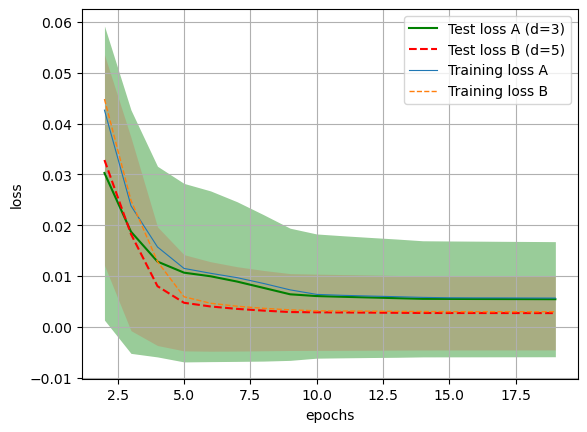

In [22]:
import numpy as np
import matplotlib.pyplot as plt

dir0 = "data/example_3_1/loss_arrays/test_cMLP_narrow"
dir1 = "data/example_3_1/loss_arrays/test_cMLP_3hidden"
dir2 = "data/example_3_1/loss_arrays/test_cMLP_5hidden"
dir3 = "data/example_3_1/loss_arrays/test_cMLP_10hidden"

dir4 = "data/example_3_1/loss_arrays/train_cMLP_narrow"
dir5 = "data/example_3_1/loss_arrays/train_cMLP_3hidden"
dir6 = "data/example_3_1/loss_arrays/train_cMLP_5hidden"
dir7 = "data/example_3_1/loss_arrays/train_cMLP_10hidden"



def load_loss_arrays(dir, idx, threshold=None):
    l = []
    for k in idx:
        arr = np.load(f"{dir}_{k}.npy")
        if threshold:
            if np.max(arr) < threshold:
                l.append(arr)
        else:
            l.append(arr)
    return np.stack(l, axis = 0)

threshold = 5
narrow = load_loss_arrays(dir0, np.arange(50), threshold)
hidden3 = load_loss_arrays(dir1, np.arange(50), threshold)
hidden5 = load_loss_arrays(dir2, np.arange(50), threshold)
hidden10 = load_loss_arrays(dir3, np.arange(50), threshold)
tr_narrow = load_loss_arrays(dir4, np.arange(50), threshold)
tr_hidden3 = load_loss_arrays(dir5, np.arange(50), threshold)
tr_hidden5 = load_loss_arrays(dir6, np.arange(50), threshold)
tr_hidden10 = load_loss_arrays(dir7, np.arange(50), threshold)

start = 2
end = 20
def avg_loss_plot(model, label=None, start=0, end=-1, linestyle='-', alpha=0.5, color=None, ):
    std = np.std(model, axis=0)[start:end]
    avg = np.average(model, axis=0)[start:end]
    u = avg-std
    o = avg+std

    x = np.arange(start, start+len(std))
    plt.fill_between(x, u,o, alpha=alpha,linewidth=0, color=color)
    plt.plot(x,avg, label=label,linestyle=linestyle, color=color)
#avg_loss_plot(narrow, 'narrow model', start,end, linestyle='--', alpha=0.3)
x = np.arange(start, start+ len(np.average(tr_hidden3, axis=0)[start:end]))
avg_loss_plot(hidden3, 'Test loss A (d=3)', start,end, alpha=0.4, color='green')
avg_loss_plot(hidden5, 'Test loss B (d=5)', start,end, alpha=0.15, linestyle='--', color='red')
plt.plot(x, np.average(tr_hidden3, axis=0)[start:end], label='Training loss A', linestyle="-", linewidth=0.8)
plt.plot(x, np.average(tr_hidden5, axis=0)[start:end], label='Training loss B', linestyle="--", linewidth=1)
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.savefig('example_3_1_plain_loss.png')
plt.show()

## Boxplot

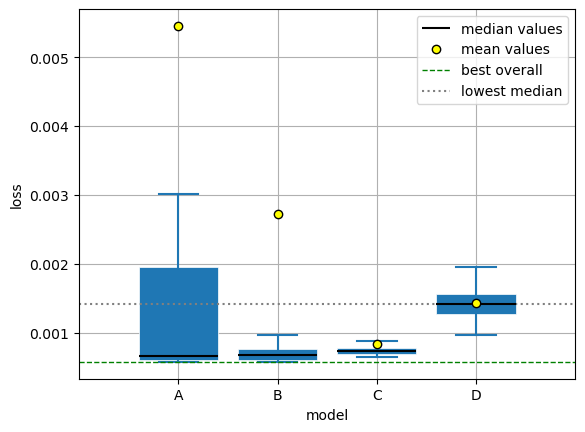

In [24]:
boxnarrow = load_loss_arrays(dir0, np.arange(50), None)
boxhidden3 = load_loss_arrays(dir1, np.arange(50), None)
boxhidden5 = load_loss_arrays(dir2, np.arange(50), None)
boxhidden10 = load_loss_arrays(dir3, np.arange(50), None)
boxavg = np.vstack(
    [
        np.min(boxhidden3, axis=1), 
        np.min(boxhidden5, axis=1),
        np.min(boxnarrow, axis=1), 
        np.min(boxhidden10, axis=1)
        ]
    )
bp = plt.boxplot(
    boxavg.T, 
    tick_labels=['A','B', 'C','D'], 
    widths=0.8, 
    patch_artist=True, 
    #meanline=True,
    showmeans=True, 
    showfliers=False,
    meanprops={'marker':'o', "markerfacecolor":"yellow", "color":"yellow","markeredgecolor":"black"},
    medianprops={"color": "black", "linewidth": 1.5},
    boxprops={"facecolor": "C0", "edgecolor": "white",
                "linewidth": 0.5},
    whiskerprops={"color": "C0", "linewidth": 1.5},
    capprops={"color": "C0", "linewidth": 1.5}
)
lower_whisker_y = bp['whiskers'][0].get_ydata()[1]
lower_median = bp['medians'][3].get_ydata()[0]
bp['means'][0].set_label('mean values')
bp['medians'][0].set_label('median values')

plt.axhline(lower_whisker_y, linestyle='--', linewidth=1, color='green', label='best overall')
plt.axhline(lower_median, linestyle=':', linewidth=1.5, color='grey', label='lowest median')

plt.xlim((0,5))

#plt.ylim(0.0224,0.0421)
plt.legend()
plt.grid()
plt.xlabel('model')
plt.ylabel('loss')
plt.savefig('example_3_1_loss_boxplot.png')
plt.show()

## Plot using errorbar

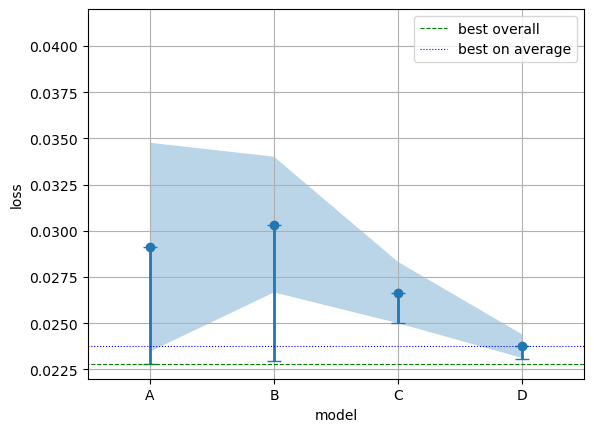

In [9]:

avg = np.array(
    [
        np.average(np.min(hidden3, axis=1)), 
        np.average(np.min(hidden5, axis=1)),
        np.average(np.min(narrow, axis=1)), 
        np.average(np.min(hidden10, axis=1))
        ]
    )
min = np.array(
    [
        np.min(hidden3), 
        np.min(hidden5),
        np.min(narrow), 
        np.min(hidden10)
        ]
    )
max = np.array(
    [
        np.max(np.min(hidden3, axis=1)), 
        np.max(np.min(hidden5, axis=1)),
        np.max(np.min(narrow, axis=1)), 
        np.max(np.min(hidden10, axis=1))
        ]
    )

std = np.array(
    [
        np.std(np.min(hidden3, axis=1)), 
        np.std(np.min(hidden5, axis=1)),
        np.std(np.min(narrow, axis=1)), 
        np.std(np.min(hidden10, axis=1))
    ]
)
avg_err=np.vstack((avg-min,np.zeros(avg.shape)))
x=['A', 'B', 'C',  'D']
minavg=np.min(avg)
minmin=np.min(min)
plt.errorbar(x=x, y=avg, yerr=avg_err, fmt='o', linewidth=2, capsize=5)
plt.hlines(minmin, xmin=-1, xmax=4, linestyle='--', color='green', linewidth = 0.8, label='best overall')
plt.hlines(minavg, xmin=-1, xmax=4, linestyle=':', color='blue', linewidth = 0.8, label='best on average')
plt.fill_between(x,avg-std, avg+std, alpha=0.3)

plt.xlim((-0.5,3.5))
plt.ylim(0.022,0.042)
plt.legend()
plt.xlabel('model')
plt.ylabel('loss')
plt.grid()
plt.show()

## Additional material Continuous grid traversal
Not in the thesis. Direction of traversal on the diagonal is reversed on every second diagonal line to prevent jump and traverse in a zig zag pattern. The continuous traversal seems to perform worse. This might be because the jumps do not impact the prediction as negatively as changing of the overall direction. - Flattening is relevant but I will argue that it is not optimal in any case.

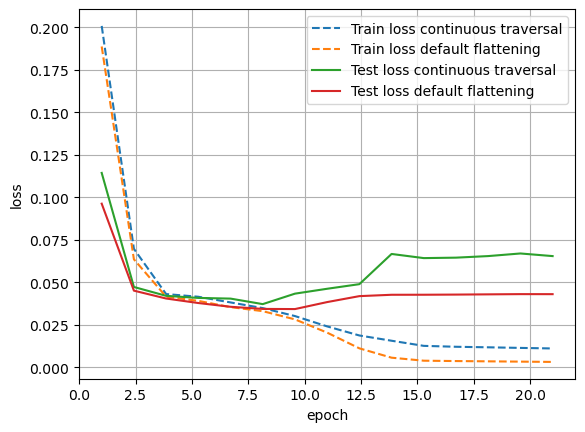

In [153]:
a,b=train(
    device = 'mps',
    dtype = torch.float32,
    model_init_dir = f"data/example_3_1/models/d4_plain_model_init.pth",
    in_features = 15028,
    out_features = 1024,
    width=32,
    depth = 2,
    activation = nn.LeakyReLU,
    residual_connection = None,
    normalization = None,
    Dropout = None,
    p = None,
    loss_fn = nn.MSELoss(),
    optimizer = torch.optim.Adam, 
    scheduler = torch.optim.lr_scheduler.StepLR,
    step_size = 10,
    epochs = 15, 
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size = 10,
    continuous_traversal=True,
    save_steps = 10,
    train_loss_file = None, 
    test_loss_file = None,
    model_dir = None,
    figure = False,
    figure_file = None
)

c,d=train(
    device = 'mps',
    dtype = torch.float32,
    model_init_dir = f"data/example_3_1/models/d4_plain_model_init.pth",
    in_features = 15028,
    out_features = 1024,
    width=32,
    depth = 4,
    activation = nn.LeakyReLU,
    residual_connection = None,
    normalization = None,
    Dropout = None,
    p = None,
    loss_fn = nn.MSELoss(),
    optimizer = torch.optim.Adam, 
    scheduler = torch.optim.lr_scheduler.StepLR,
    step_size = 10,
    epochs = 15, 
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size = 10,
    continuous_traversal=False,
    save_steps = 10,
    train_loss_file = None, 
    test_loss_file = None,
    model_dir = None,
    figure = False,
    figure_file = None
)

clear_output()
start = 0
end = 20
x= np.linspace(start+1,end+1,len(a[start:end]))


plt.plot(x, a[start:end],label='Train loss continuous traversal', linestyle='--')
plt.plot(x, c[start:end],label='Train loss default flattening', linestyle='--')
plt.plot(x, b[start:end],label='Test loss continuous traversal', linestyle='-')
plt.plot(x, d[start:end],label='Test loss default flattening', linestyle='-')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()
